In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Load your preprocessed dataset
data = pd.read_csv('/content/preprocessed_dataset.csv')



In [2]:
# 'cleaned_comment' is the preprocessed comment text and 'labels' is the sarcasm label (0 or 1)
X = data['cleaned_comment']
y = data['labels']



In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
# Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [5]:
# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the data for the LSTM model
X_train = np.expand_dims(X_train_tfidf.toarray(), axis=1)  # Convert sparse matrix to dense array and add time step dimension
X_test = np.expand_dims(X_test_tfidf.toarray(), axis=1)    # Convert sparse matrix to dense array and add time step dimension



In [6]:
# Build the LSTM model with regularization and batch normalization
model = Sequential()
model.add(LSTM(units=256, input_shape=(1, X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))  # For binary classification



In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            5383168   
                                                                 
 batch_normalization (Batch  (None, 1, 256)            1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 batch_normalization_1 (Bat  (None, 1, 128)            512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
389/389 [==============================] - 29s 27ms/step - loss: 4.7632 - accuracy: 0.6859 - val_loss: 2.8005 - val_accuracy: 0.5730
Epoch 2/10
389/389 [==============================] - 7s 18ms/step - loss: 1.7190 - accuracy: 0.7523 - val_loss: 1.2413 - val_accuracy: 0.7082
Epoch 3/10
389/389 [==============================] - 7s 17ms/step - loss: 0.9478 - accuracy: 0.7654 - val_loss: 0.8572 - val_accuracy: 0.7362
Epoch 4/10
389/389 [==============================] - 7s 19ms/step - loss: 0.7405 - accuracy: 0.7685 - val_loss: 0.7839 - val_accuracy: 0.7487
Epoch 5/10
389/389 [==============================] - 6s 17ms/step - loss: 0.6855 - accuracy: 0.7792 - val_loss: 0.7518 - val_accuracy: 0.7436
Epoch 6/10
389/389 [==============================] - 8s 20ms/step - loss: 0.6511 - accuracy: 0.7949 - val_loss: 0.6761 - val_accuracy: 0.7532
Epoch 7/10
389/389 [==============================] - 7s 17ms/step - loss: 0.6346 - accuracy: 0.8058 - val_loss: 0.7066 - val_accuracy: 0.735

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predict on test data
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate F1 score
f1 = f1_score(y_test, y_test_pred)
print(f"Test F1 Score: {f1}")



122/122 [==============================] - 1s 6ms/step - loss: 0.7137 - accuracy: 0.7284
Test Accuracy: 0.7283728122711182
122/122 [==============================] - 2s 4ms/step
Test F1 Score: 0.7119847119847119


In [11]:
# Print classification report
print(classification_report(y_test, y_test_pred))



              precision    recall  f1-score   support

           0       0.79      0.70      0.74      2178
           1       0.67      0.76      0.71      1706

    accuracy                           0.73      3884
   macro avg       0.73      0.73      0.73      3884
weighted avg       0.74      0.73      0.73      3884



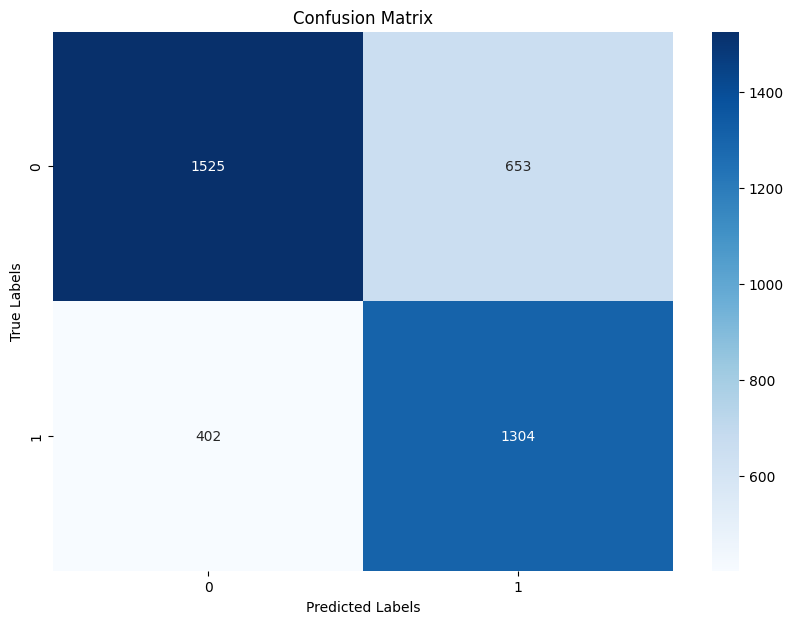

In [12]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()